In [1]:
#import modules

import numpy as np
import pandas as pd
import random
from collections import deque
from sklearn import preprocessing

In [2]:
#define parameters

PAST_SEQ = 60  #past data sequence to be formed as LSTM input
FUTURE_SEQ = 3  #future data sequence to be predicted

In [3]:
#classifying data as a rise or fall in price. Rise - 1, Fall - 0.

def rise_or_fall(current,future):
    if float(future) > float(current): 
        return 1
    else:
        return 0

In [13]:
#forming the dataframe

main_df = pd.DataFrame()
dataset = 'BTC-data.csv'
df=pd.read_csv(dataset, names=['Time', 'Low', 'High', 'Open', 'Close', 'Volume'])
df.set_index("Time", inplace=True) 

df=df[["Close", "Volume"]]                     #ignore all columns except close and volume

if len(main_df)==0:
    main_df=df
else:
    main_df=main_df.join(df)                   #forming the main dataframe

main_df.dropna(inplace=True)                   #remove all NA values

main_df['Future'] = main_df[f'Close'].shift(-FUTURE_SEQ)   #adding a column of future values by using shift of 3 minutes
main_df['Rise/Fall'] = list(map(rise_or_fall, main_df[f'Close'], main_df['Future']))

main_df.dropna(inplace=True)
main_df.head(20)

,Close,Volume,Future,Rise/Fall
Time,,,,
1528968660,6489.549805,0.587100,6479.410156,0
1528968720,6487.379883,7.706374,6479.979980,0
1528968780,6479.410156,3.088252,6480.000000,1
1528968840,6479.410156,1.404100,6477.220215,0
1528968900,6479.979980,0.753000,6480.000000,1
1528968960,6480.000000,1.490900,6479.990234,0
1528969020,6477.220215,2.731950,6478.660156,1
1528969080,6480.000000,2.174240,6478.660156,0
1528969140,6479.990234,0.903100,6479.339844,0


In [14]:
main_df['Close'] = main_df['Close'].pct_change().dropna()
main_df['Close'] = preprocessing.scale(main_df['Close'].values)
main_df.head(10)

,Close,Volume,Future,Rise/Fall
Time,,,,
1528968660,NaN,0.587100,6479.410156,0
1528968720,-0.396434,7.706374,6479.979980,0
1528968780,-1.454279,3.088252,6480.000000,1
1528968840,-0.000836,1.404100,6477.220215,0
1528968900,0.103211,0.753000,6480.000000,1
1528968960,0.002819,1.490900,6479.990234,0
1528969020,-0.508364,2.731950,6478.660156,1
1528969080,0.506909,2.174240,6478.660156,0
1528969140,-0.002619,0.903100,6479.339844,0


In [39]:
def preprocess_dataframe(dataframe):
    for column in dataframe.columns:
        if column != "Rise/Fall":
            dataframe[column] = dataframe[column].pct_change().dropna()  # Normalizes the difference between each field's values
            dataframe[column] = preprocessing.scale(dataframe[column].values)  # Scale between 0 and 1
    dataframe.dropna(inplace=True)
    
    sequence_data = []  # Contains the sequence data
    previous_seq = deque(maxlen=PAST_SEQ)  # Actual sequence of max size PAST_SEQ
    
    for row in dataframe.values:
        previous_seq.append([value for value in row[:-1]])  # All the features of the previous days
        if len(previous_seq) == PAST_SEQ:  # To make sure we have a sequence of only PAST_SEQ values
            sequence_data.append([np.array(previous_seq), row[-1]])  # Sequence data now has the features and the target variable
    random.shuffle(sequence_data)
    
    buys = []  # Buy sequence
    sells = []  # Sell sequence
    
    for sequence, target in sequence_data:  # Iterate over the sequential data 
        if target == 0: 
            sells.append([sequence, target])  # Append to the sell sequence
        else: 
            buys.append([sequence, target])  # Append to the buy sequence 
    
    random.shuffle(buys)
    random.shuffle(sells)
    
    balance = min(len(buys), len(sells))
    buys = buys[:balance]
    sells = sells[:balance]
    sequence_data = buys + sells
    random.shuffle(sequence_data)
    
    x_data = []
    y_data = []
    
    for sequence, target in sequence_data: 
        x_data.append(sequence)  # x_data is the sequence
        y_data.append(target)    # y_data is the target (whether to buy or sell)
        
    return np.array(x_data), y_data

In [41]:
from sklearn.model_selection import train_test_split

# splitting the data into train and validation sets
time = sorted(main_df.index.values)
split_index = int(0.85 * len(time))  # 85% train, 15% validation

train_data, validation_data = train_test_split(main_df, train_size=split_index, shuffle=False)

train_x, train_y = preprocess_dataframe(train_data)
validation_x, validation_y = preprocess_dataframe(validation_data)

print(f"Train data: {len(train_x)} Validation data: {len(validation_x)}")
print(f"Train Dont buys: {train_y.count(0)} Train Buys: {train_y.count(1)}")
print(f"Validation Dont buys: {validation_y.count(0)} Validation buys: {validation_y.count(1)}")


Train data: 74026 Validation data: 13594
Train Dont buys: 37013 Train Buys: 37013
Validation Dont buys: 6797 Validation buys: 6797


In [42]:
#model constants

import time

EPOCHS = 15
BATCH_SIZE=64

train_x = np.asarray(train_x)
train_y = np.asarray(train_y)
validation_x = np.asarray(validation_x)
validation_y = np.asarray(validation_y)
print(train_x.shape)

(74026, 60, 3)


In [43]:
#model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Dense, Dropout,LSTM, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

In [44]:
model = Sequential()
#1st LSTM layer, followed by dropout for reducing overfitting, and then normaization of the inputs
model.add(LSTM(128, input_shape=(tarain_x.shape[1:]), return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())
#layer2 of LSTM, dropout and batchnormalization
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())
#layer3
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.1))
model.add(BatchNormalization())
#layer4
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
#layer5
model.add(Dense(2, activation='softmax'))

In [46]:
optim = tf.keras.optimizers.Adam(lr=0.001)
model.compile(loss='sparse_categorical_crossentropy',
             optimizer=optim,
             metrics=['accuracy']
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 128)           67584     
                                                                 
 dropout (Dropout)           (None, 60, 128)           0         
                                                                 
 batch_normalization (Batch  (None, 60, 128)           512       
 Normalization)                                                  
                                                                 
 lstm_1 (LSTM)               (None, 60, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 60, 128)           0         
                                                                 
 batch_normalization_1 (Bat  (None, 60, 128)           512       
 chNormalization)                                       

In [48]:
#training the model
history=model.fit(train_x, train_y, 
                  batch_size=BATCH_SIZE, 
                  epochs=EPOCHS,
                  validation_data=(validation_x,validation_y)
)

Epoch 1/15
1157/1157 [==============================] - 221s 191ms/step - loss: 0.2702 - accuracy: 0.8701 - val_loss: 0.2826 - val_accuracy: 0.8722
Epoch 2/15
1157/1157 [==============================] - 214s 185ms/step - loss: 0.2132 - accuracy: 0.8938 - val_loss: 0.1580 - val_accuracy: 0.9218
Epoch 3/15
1157/1157 [==============================] - 228s 197ms/step - loss: 0.2036 - accuracy: 0.9009 - val_loss: 0.1684 - val_accuracy: 0.9153
Epoch 4/15
1157/1157 [==============================] - 226s 195ms/step - loss: 0.1934 - accuracy: 0.9040 - val_loss: 0.1514 - val_accuracy: 0.9275
Epoch 5/15
1157/1157 [==============================] - 257s 222ms/step - loss: 0.1889 - accuracy: 0.9069 - val_loss: 0.1445 - val_accuracy: 0.9275
Epoch 6/15
1157/1157 [==============================] - 268s 231ms/step - loss: 0.1844 - accuracy: 0.9096 - val_loss: 0.1417 - val_accuracy: 0.9300
Epoch 7/15
1157/1157 [==============================] - 265s 229ms/step - loss: 0.1825 - accuracy: 0.9099 - val_

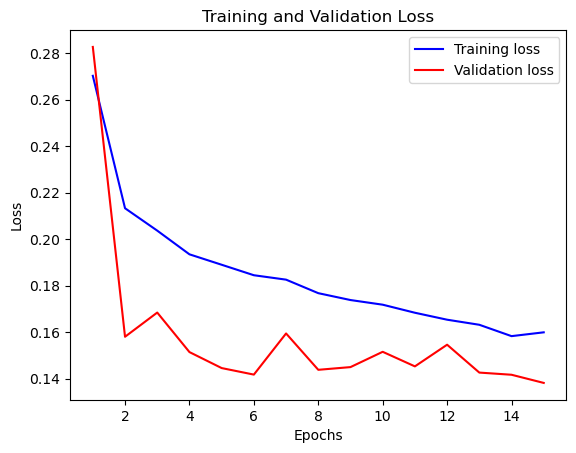

In [55]:
import matplotlib.pyplot as plt

# Retrieve training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create an array of epochs
epochs = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [49]:
#score of the model
mod_score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss: ', mod_score[0])
print('Test Accuracy: ', mod_score[1])

NAME = "BITCOIN Predictor"
#save model
model.save("models/{}".format(NAME))

Test loss:  0.13811033964157104
Test Accuracy:  0.9331322908401489
INFO:tensorflow:Assets written to: models/BITCOIN Predictor\assets


INFO:tensorflow:Assets written to: models/BITCOIN Predictor\assets


In [50]:
losses = pd.DataFrame(model.history.history)

In [51]:
model.metrics_names

['loss', 'accuracy']

In [52]:
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
model = keras.models.load_model('models/BITCOIN Predictor')
min_max_scaler=MinMaxScaler()

In [53]:
test_set=validation_x
predicted_price=model.predict(test_set)

425/425 [==============================] - 18s 40ms/step


In [78]:
for i in range(10):
    print("Actual Target: ", validation_y[i])

    print("Predicted Target: ", int(np.argmax(predicted_price[i])))
    print(predicted_price[i])

Actual Target:  0.0
Predicted Target:  0
[0.9988337  0.00116632]
Actual Target:  1.0
Predicted Target:  1
[1.8773077e-05 9.9998128e-01]
Actual Target:  1.0
Predicted Target:  1
[2.6198165e-07 9.9999976e-01]
Actual Target:  0.0
Predicted Target:  0
[9.9999666e-01 3.2866983e-06]
Actual Target:  0.0
Predicted Target:  0
[0.8685339  0.13146605]
Actual Target:  1.0
Predicted Target:  1
[4.2128633e-07 9.9999952e-01]
Actual Target:  1.0
Predicted Target:  1
[1.7870451e-06 9.9999821e-01]
Actual Target:  0.0
Predicted Target:  0
[0.7992513  0.20074861]
Actual Target:  0.0
Predicted Target:  0
[0.77412236 0.22587769]
Actual Target:  1.0
Predicted Target:  1
[3.739784e-06 9.999963e-01]


In [70]:
print(test_set[0])
print(test_set[1])
# print(len(validation_x[0]))

[[-4.31807798e-02 -1.38889135e-01  2.66704197e-01]
 [ 1.99345381e-01  1.68414922e-01 -1.02209238e-02]
 [ 2.21799155e-01 -1.38664833e-01  8.95107230e-05]
 [ 2.66725450e-01 -1.06186423e-01  8.20532049e-01]
 [-1.01991886e-02  3.91776410e-02 -5.06571802e-03]
 [ 1.11227950e-04 -1.26657841e-01 -1.60311546e-03]
 [ 8.20552337e-01 -1.32992529e-01  2.23291027e-01]
 [-5.04399182e-03 -1.31079915e-01 -3.37695670e-03]
 [-1.58139529e-03 -8.05037233e-02 -5.06571802e-03]
 [ 2.23312355e-01  1.39507406e-01 -5.06571802e-03]
 [-3.35523344e-03 -1.08838886e-01  1.17702347e-01]
 [-5.04399182e-03 -1.38159854e-01  4.50831613e-02]
 [-5.04399182e-03 -8.31842884e-02  1.55100209e+00]
 [ 1.17723860e-01 -1.24466142e-01  8.56568912e-01]
 [ 4.51048002e-02 -6.19923650e-02 -2.38005605e-01]
 [ 1.55102110e+00  2.02286371e-01  4.98826435e-01]
 [ 8.56589137e-01 -1.35882960e-01 -1.61253499e-03]
 [-2.37983473e-01 -6.31357179e-02  4.72748235e-01]
 [ 4.98847283e-01 -1.28825636e-01 -6.37469697e-02]
 [-1.59081480e-03 -1.35793306e-